In [3]:
import os
import sqlite3
import pandas as pd

# Function to load restaurant data
def load_restaurant_data(db_file, db_id, c, m=50):
    """Load and calculate weighted ratings for restaurant data from specified database."""
    if not os.path.exists(db_file):
        print(f"Error: {db_file} does not exist.")
        return pd.DataFrame()

    queries = {
        "deliveroo": f"""
            SELECT 
                name AS restaurant_name, 
                address, postal_code, uname,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                rating, CAST(rating_number AS INTEGER) AS rating_number,
                ((rating_number * rating) + ({m} * {c})) / (rating_number + {m}) AS weighted_rating,
                prep_time, delivery_time, min_order, delivery_fee,
                (CAST(delivery_fee AS REAL) + CAST(min_order AS REAL)) AS combined_cost
            FROM restaurants
            WHERE rating IS NOT NULL AND rating_number > 0 AND delivery_fee IS NOT NULL AND min_order IS NOT NULL
        """,
        "takeaway": f"""
            SELECT 
                r.name AS restaurant_name, 
                r.address, r.city, r.primarySlug AS restaurant_id,
                CAST(r.longitude AS REAL) AS longitude, 
                CAST(r.latitude AS REAL) AS latitude, 
                r.ratings AS rating, CAST(r.ratingsNumber AS INTEGER) AS rating_number,
                ((r.ratingsNumber * r.ratings) + ({m} * {c})) / (r.ratingsNumber + {m}) AS weighted_rating,
                l.postalCode AS postal_code,
                CAST(r.deliveryFee AS REAL) AS delivery_fee, CAST(r.minOrder AS REAL) AS min_order,
                (CAST(r.deliveryFee AS REAL) + CAST(r.minOrder AS REAL)) AS combined_cost
            FROM restaurants r
            LEFT JOIN (
                SELECT
                    lr.restaurant_id, l.postalCode
                FROM locations_to_restaurants lr
                JOIN locations l ON lr.location_id = l.ID
                WHERE l.postalCode IS NOT NULL
            ) l ON r.primarySlug = l.restaurant_id
            WHERE r.ratings IS NOT NULL AND r.ratingsNumber > 0 AND r.deliveryFee IS NOT NULL AND r.minOrder IS NOT NULL
        """
    }

    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(queries[db_id], conn)
        if df.empty:
            print(f"Warning: No data from {db_id}.")
        df['longitude'] = df['longitude'].round(6)
        df['latitude'] = df['latitude'].round(6)
        df['source'] = db_id
        return df
    except sqlite3.OperationalError as e:
        print(f"Error with {db_id}: {e}")
        return pd.DataFrame()
    finally:
        conn.close()

# Define database files and identifiers
db_files = [
    ("databases_uc/deliveroo.db", "deliveroo"),
    ("databases_uc/takeaway.db", "takeaway")
]

# Load and combine data
dataframes = [load_restaurant_data(file, db_id, c=4.0, m=50) for file, db_id in db_files]
stacked_df = pd.concat(dataframes, ignore_index=True)

# Fill missing values
stacked_df['city'] = stacked_df.get('city', pd.Series()).fillna("Unknown")
stacked_df['postal_code'] = stacked_df.get('postal_code', pd.Series()).fillna("Unknown")
stacked_df['address'] = stacked_df['address'].fillna("Unknown")
stacked_df['rating'] = stacked_df['rating'].fillna(0.0)

# Ensure delivery_fee and min_order are numeric
stacked_df['delivery_fee'] = pd.to_numeric(stacked_df['delivery_fee'], errors='coerce').fillna(0)
stacked_df['min_order'] = pd.to_numeric(stacked_df['min_order'], errors='coerce').fillna(0)

# Filter out restaurants where both delivery_fee and min_order are 0
stacked_df = stacked_df[(stacked_df['delivery_fee'] > 0) | (stacked_df['min_order'] > 0)]

# Drop duplicates based on restaurant_name, address, rating, and source
stacked_df = stacked_df.drop_duplicates(subset=['restaurant_name', 'address', 'rating_number', 'source'])

# Normalize restaurant names for merging
stacked_df['normalized_name'] = stacked_df['restaurant_name'].str.strip().str.lower()

# Separate data by platform
deliveroo_df = stacked_df[stacked_df['source'] == 'deliveroo']
takeaway_df = stacked_df[stacked_df['source'] == 'takeaway']

# Merge data on normalized names
mutual_df = pd.merge(
    deliveroo_df,
    takeaway_df,
    on='normalized_name',
    suffixes=('_deliveroo', '_takeaway')
)

# Select relevant columns for the analysis
mutual_analysis_df = mutual_df[[
    'normalized_name',
    'rating_deliveroo', 'rating_takeaway',
    'rating_number_deliveroo', 'rating_number_takeaway',
    'delivery_fee_deliveroo', 'delivery_fee_takeaway',
    'min_order_deliveroo', 'min_order_takeaway',
    'combined_cost_deliveroo', 'combined_cost_takeaway',
    'city_deliveroo', 'city_takeaway',
    'postal_code_deliveroo', 'postal_code_takeaway'
]]

# Display mutual analysis dataframe
print(mutual_analysis_df.head())


  normalized_name  rating_deliveroo  rating_takeaway  rating_number_deliveroo  \
0        bia mara               4.3              4.1                      121   
1        bia mara               4.3              4.3                      121   
2   balls & glory               4.5              4.6                      500   
3   balls & glory               4.5              4.2                      500   
4   balls & glory               4.5              3.9                      500   

   rating_number_takeaway  delivery_fee_deliveroo  delivery_fee_takeaway  \
0                      13                    4.99                   5.59   
1                      83                    4.99                   2.99   
2                       6                    4.99                   3.49   
3                      96                    4.99                   4.84   
4                     182                    4.99                   4.84   

   min_order_deliveroo  min_order_takeaway  combined_cos

Total rows after processing: 5319
               restaurant_name                     address postal_code  \
59738  De Echte Eethuis Carlos       Herseltsesteenweg 207        2230   
8438                 Veziroglu  Franklin Rooseveltlaan 100        1800   
2633            Snack Thieffry              Rue Pervyse 62        1140   
4068                 Sushiline     Chaussée De Louvain 470        1140   
60904              Snack Dekan   Place Cardinal Mercier 41        1731   

          unique_restaurant_id  longitude   latitude  rating  rating_count  \
59738  eethuis-carlos-aarschot   4.835920  51.002308     5.0           599   
8438                 veziroglu   4.425172  50.931044     5.0           455   
2633            snack-thieffry   4.399869  50.830792     4.9          3875   
4068       sushiline-bruxelles   4.391012  50.853172     4.9          3036   
60904              snack-dekan   4.329693  50.880092     4.9          2845   

       weighted_rating  prep_time  delivery_time  to

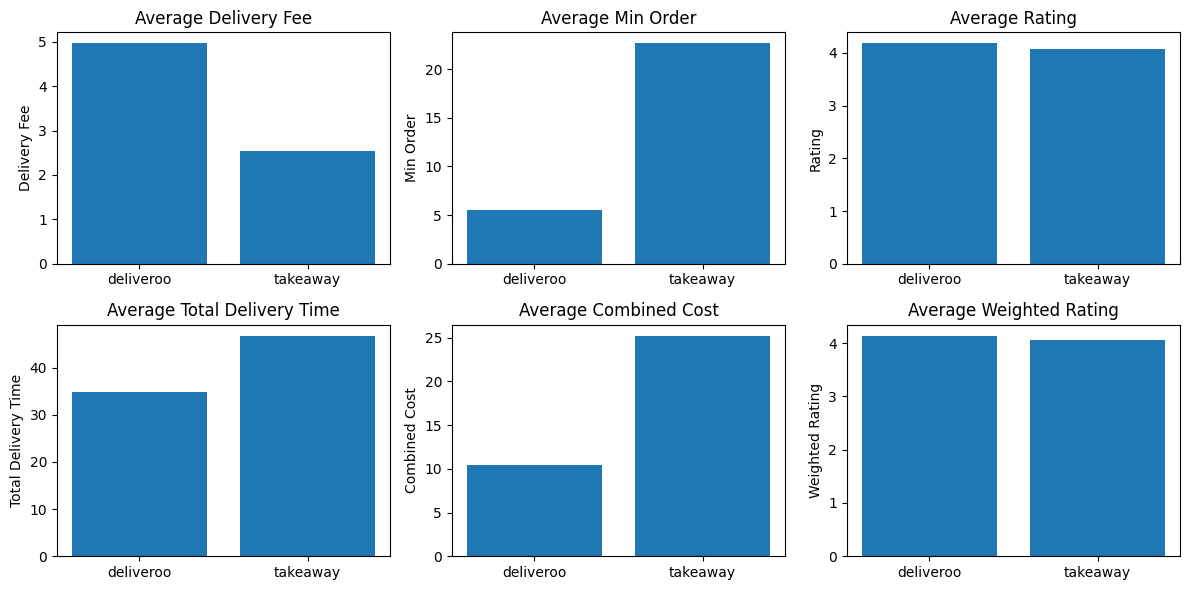

In [6]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


def clean_numeric_column(column):
    """
    Cleans a numeric column by removing invalid characters and converting to float.
    Invalid entries are replaced with NaN.
    """
    return pd.to_numeric(column.replace(r'[^\d.]', '', regex=True), errors='coerce')


def load_restaurant_data(db_file, db_id, c, m=50):
    """
    Load and calculate weighted ratings for restaurant data from a specified database.
    """
    if not os.path.exists(db_file):
        print(f"Error: {db_file} does not exist.")
        return pd.DataFrame()

    # Define queries for each database
    queries = {
        "deliveroo": f"""
            SELECT 
                name AS restaurant_name, 
                address, postal_code, uname AS unique_restaurant_id,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                rating, rating_number AS rating_count,
                ((rating_number * rating) + ({m} * {c})) / (rating_number + {m}) AS weighted_rating,
                prep_time, delivery_time, 
                (prep_time + delivery_time) AS total_delivery_time,
                delivery_fee, 
                min_order,
                (delivery_fee + min_order) AS combined_cost
            FROM restaurants
            WHERE rating IS NOT NULL AND rating_number > 0
        """,
        "takeaway": f"""
            SELECT 
                r.name AS restaurant_name, 
                r.address, r.city, r.primarySlug AS unique_restaurant_id,
                CAST(r.longitude AS REAL) AS longitude, 
                CAST(r.latitude AS REAL) AS latitude, 
                r.ratings AS rating, r.ratingsNumber AS rating_count,
                ((r.ratingsNumber * r.ratings) + ({m} * {c})) / (r.ratingsNumber + {m}) AS weighted_rating,
                l.postalCode AS postal_code,
                r.deliveryFee AS delivery_fee, 
                r.minOrder AS min_order,
                (r.deliveryFee + r.minOrder) AS combined_cost,
                ((r.durationRangeMin + r.durationRangeMax) / 2) AS total_delivery_time
            FROM restaurants r
            LEFT JOIN (
                SELECT
                    lr.restaurant_id, l.postalCode
                FROM locations_to_restaurants lr
                JOIN locations l ON lr.location_id = l.ID
                WHERE l.postalCode IS NOT NULL
            ) l ON r.primarySlug = l.restaurant_id
            WHERE r.ratings IS NOT NULL AND r.ratingsNumber > 0
        """
    }

    try:
        # Connect to the database and execute the query
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(queries[db_id], conn)

        # Clean numeric columns to handle invalid values
        numeric_columns = ['rating', 'rating_count', 'delivery_fee', 'min_order', 'total_delivery_time', 'combined_cost']
        for col in numeric_columns:
            if col in df.columns:
                df[col] = clean_numeric_column(df[col])

        df['source'] = db_id  # Add source identifier
        return df
    except sqlite3.OperationalError as e:
        print(f"Error querying {db_id}: {e}")
        return pd.DataFrame()
    finally:
        conn.close()


# Define database files and identifiers
db_files = [
    ("databases_uc/deliveroo.db", "deliveroo"),
    ("databases_uc/takeaway.db", "takeaway")
]

# Load and combine data
dataframes = [load_restaurant_data(file, db_id, c=4.0, m=50) for file, db_id in db_files]
stacked_df = pd.concat(dataframes, ignore_index=True)

# Fill missing values
fill_values = {
    'city': 'Unknown',
    'postal_code': 'Unknown',
    'address': 'Unknown',
    'rating': 0.0,
    'delivery_fee': 0.0,
    'min_order': 0.0,
    'total_delivery_time': 0.0,
    'combined_cost': 0.0
}
stacked_df.fillna(value=fill_values, inplace=True)

# Drop duplicates
stacked_df.drop_duplicates(subset=['restaurant_name', 'address', 'source'], inplace=True)

# Sort by weighted_rating
stacked_df.sort_values(by='weighted_rating', ascending=False, inplace=True)

# Display the processed data
print(f"Total rows after processing: {stacked_df.shape[0]}")
print(stacked_df.head())

# Calculate platform averages
platforms = ['deliveroo', 'takeaway']
metrics = ['delivery_fee', 'min_order', 'rating', 'total_delivery_time', 'combined_cost', 'weighted_rating']
averages = {platform: {metric: stacked_df[stacked_df['source'] == platform][metric].mean() for metric in metrics} for platform in platforms}

# Visualization
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics, start=1):
    plt.subplot(2, 3, i)
    plt.bar(platforms, [averages[p][metric] for p in platforms])
    plt.title(f'Average {metric.replace("_", " ").title()}')
    plt.ylabel(metric.replace("_", " ").title())

plt.tight_layout()
plt.show()


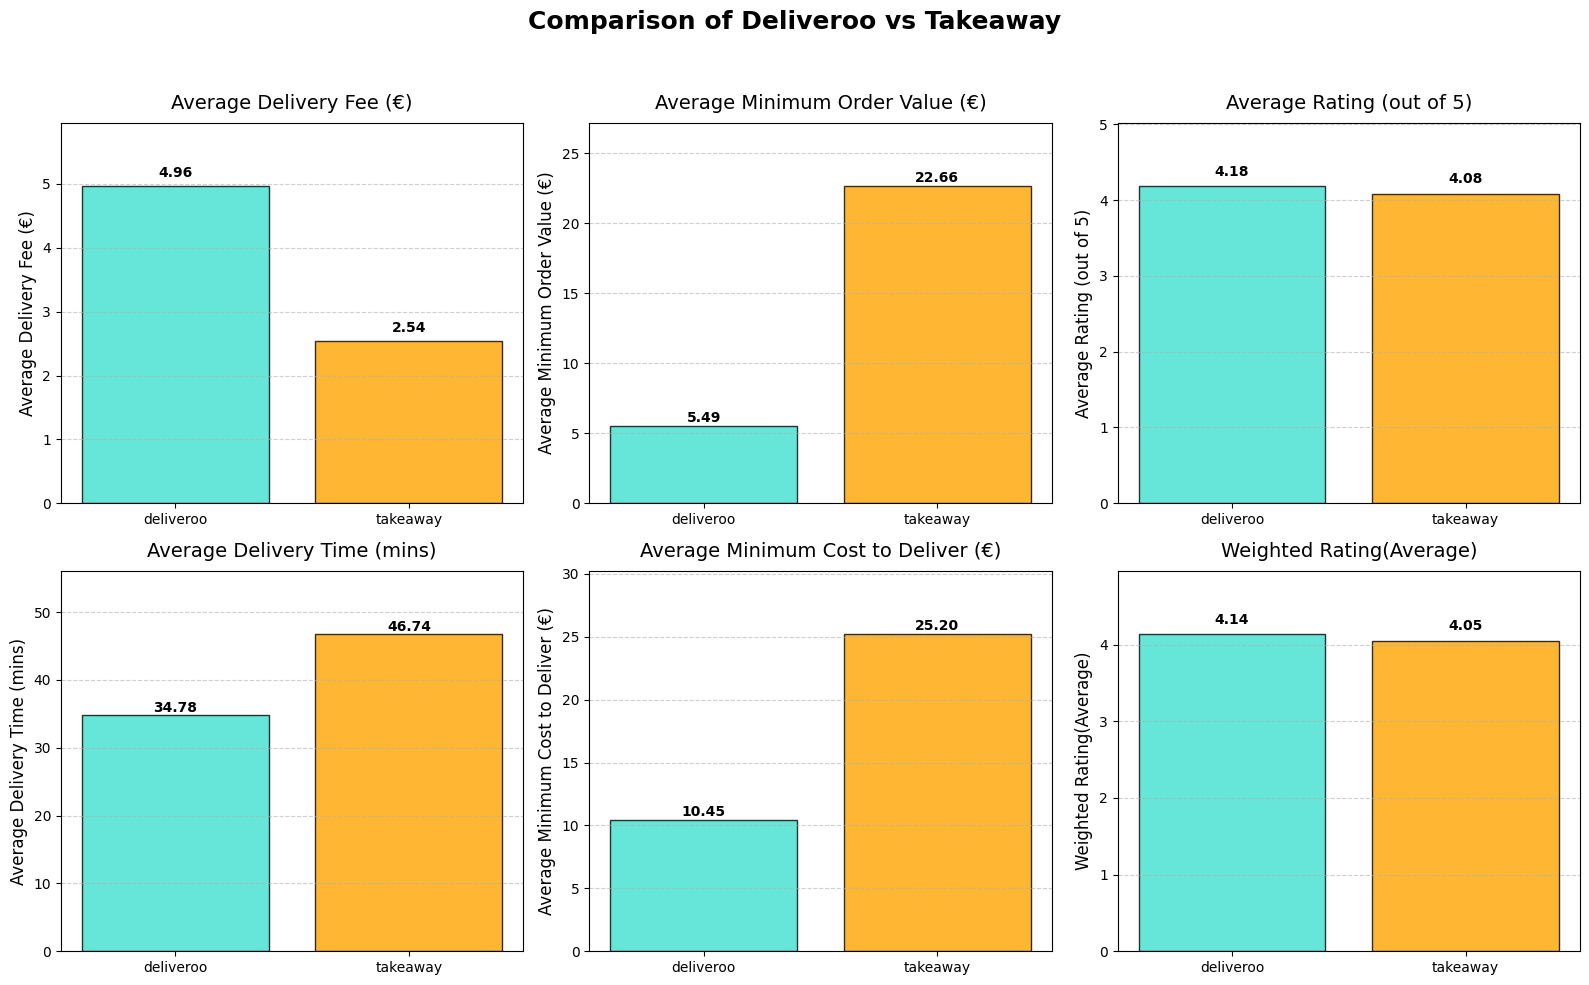

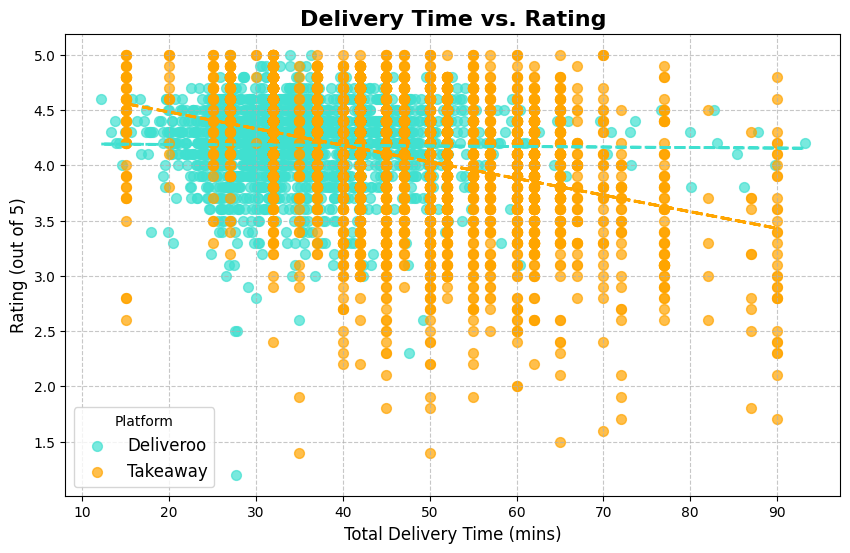

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for platforms
colors = {'deliveroo': 'turquoise', 'takeaway': 'orange'}

# Set up metrics and platforms
metrics = ['delivery_fee', 'min_order', 'rating', 'total_delivery_time', 'combined_cost', 'weighted_rating']
metric_labels = [
    'Average Delivery Fee (€)', 'Average Minimum Order Value (€)', 'Average Rating (out of 5)',
    'Average Delivery Time (mins)', 'Average Minimum Cost to Deliver (€)', 'Weighted Rating(Average)'
]

# Extract average values for each platform and metric
avg_values = {metric: [averages[platform][metric] for platform in platforms] for metric in metrics}

# Create the figure
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Comparison of Deliveroo vs Takeaway', fontsize=18, fontweight='bold')

# Plot each metric in its subplot
for ax, metric, label in zip(axes.flat, metrics, metric_labels):
    values = avg_values[metric]
    bars = ax.bar(platforms, values, color=[colors[p] for p in platforms], alpha=0.8, edgecolor='black')
    
    # Annotate bars with exact values
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f"{value:.2f}", 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Customize axes
    ax.set_title(label, fontsize=14, pad=10)
    ax.set_ylabel(label, fontsize=12)
    ax.set_ylim(0, max(values) * 1.2)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Enhanced Scatter Plot for Delivery Time vs Rating
plt.figure(figsize=(10, 6))
for platform, color in colors.items():
    subset = stacked_df[stacked_df['source'] == platform]
    plt.scatter(subset['total_delivery_time'], subset['rating'], label=platform.capitalize(), alpha=0.7, color=color, s=50)

# Add titles, labels, and legend
plt.title('Delivery Time vs. Rating', fontsize=16, fontweight='bold')
plt.xlabel('Total Delivery Time (mins)', fontsize=12)
plt.ylabel('Rating (out of 5)', fontsize=12)
plt.legend(title="Platform", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add trend lines for each platform
for platform, color in colors.items():
    subset = stacked_df[stacked_df['source'] == platform]
    z = np.polyfit(subset['total_delivery_time'], subset['rating'], 1)  # Fit a line
    p = np.poly1d(z)
    plt.plot(subset['total_delivery_time'], p(subset['total_delivery_time']), color=color, linestyle='--', linewidth=2)

plt.show()


Rating Distribution Across Platforms:
            count      mean       std  min  25%  50%  75%  max
source                                                        
deliveroo  1690.0  4.181361  0.344459  1.2  4.0  4.2  4.4  5.0
takeaway   3630.0  4.079449  0.558046  1.4  3.8  4.2  4.5  5.0
ubereats   1093.0  4.295700  0.407181  1.1  4.1  4.4  4.6  5.0


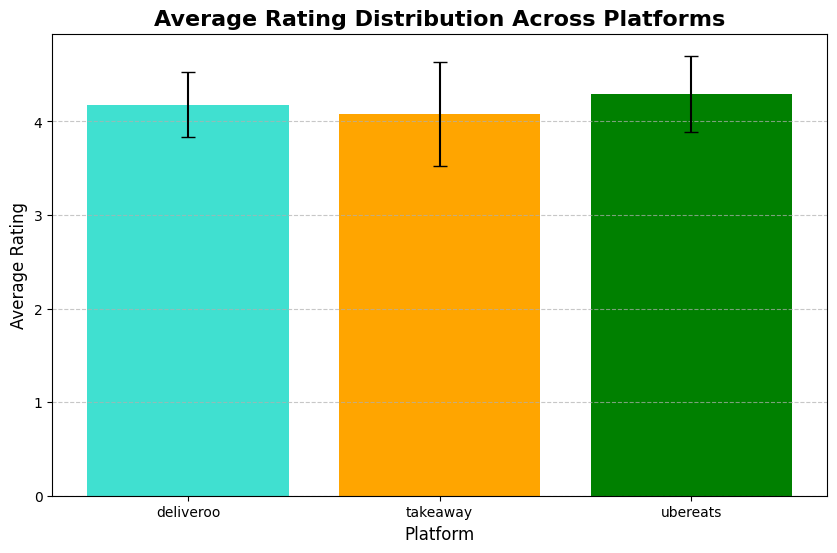

Count and Mean Rating for Each Platform:
           count      mean
source                    
deliveroo   1690  4.181361
takeaway    3630  4.079449
ubereats    1093  4.295700


Text(0, 0.5, 'Count')

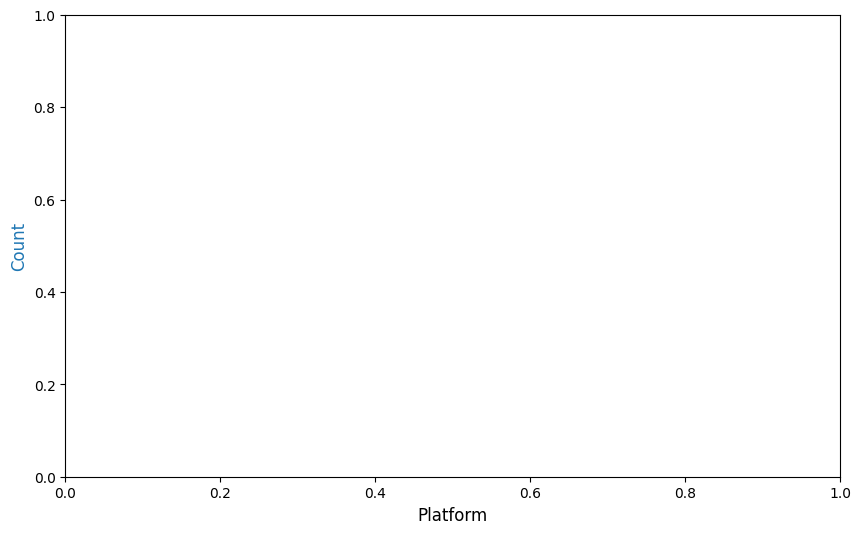

In [14]:
import sqlite3
import pandas as pd

# Step 1: Load Databases
deliveroo_db = 'databases_uc/deliveroo.db'
takeaway_db = 'databases_uc/takeaway.db'
ubereats_db = 'databases_uc/ubereats.db'

# Step 2: Function to Fetch Restaurant Ratings from Each Database
def fetch_restaurant_ratings(db_file, db_id):
    conn = sqlite3.connect(db_file)
    query = None
    if db_id == "deliveroo":
        query = """
        SELECT name AS restaurant_name, rating, CAST(rating_number AS INTEGER) AS rating_count
        FROM restaurants
        WHERE rating IS NOT NULL AND rating_number > 0;
        """
    elif db_id == "takeaway":
        query = """
        SELECT name AS restaurant_name, ratings AS rating, CAST(ratingsNumber AS INTEGER) AS rating_count
        FROM restaurants
        WHERE ratings IS NOT NULL AND ratingsNumber > 0;
        """
    elif db_id == "ubereats":
        query = """
        SELECT title AS restaurant_name, rating__rating_value AS rating, CAST(rating__review_count AS INTEGER) AS rating_count
        FROM restaurants
        WHERE rating__rating_value IS NOT NULL AND rating__review_count > 0;
        """
    else:
        return pd.DataFrame()  # Return empty DataFrame if db_id is invalid
    df = pd.read_sql_query(query, conn)
    conn.close()
    df['source'] = db_id
    return df

# Step 3: Fetch Data from All Platforms
df_deliveroo = fetch_restaurant_ratings(deliveroo_db, "deliveroo")
df_takeaway = fetch_restaurant_ratings(takeaway_db, "takeaway")
df_ubereats = fetch_restaurant_ratings(ubereats_db, "ubereats")

# Combine data into one DataFrame
df_ratings = pd.concat([df_deliveroo, df_takeaway, df_ubereats], ignore_index=True)

# Step 4: Normalize Restaurant Names for Cross-Platform Comparison
df_ratings['restaurant_name_clean'] = df_ratings['restaurant_name'].str.lower().str.strip()

# Analysis 1: Rating Distribution Across Platforms
rating_distribution = df_ratings.groupby('source')['rating'].describe()
print("Rating Distribution Across Platforms:")
print(rating_distribution)


# Plotting the rating distribution across platforms
plt.figure(figsize=(10, 6))
plt.bar(rating_distribution.index, rating_distribution['mean'], yerr=rating_distribution['std'], capsize=5, color=['turquoise', 'orange', 'green'])
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.title('Average Rating Distribution Across Platforms', fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Analysis 2: Display Count and Mean Rating for Each Platform
rating_summary = df_ratings.groupby('source')['rating'].agg(['count', 'mean'])
print("Count and Mean Rating for Each Platform:")
print(rating_summary)

# Plotting the count and mean rating for each platform
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Platform', fontsize=12)
ax1.set_ylabel('Count', color=color, fontsize=12)